In [1]:
import torch 
import torchvision 
import tarfile 
from tqdm import tqdm 
import torch.nn as nn 
import torch.nn.functional as F 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor 
import numpy as np
from torchsummary import summary 
import matplotlib.pyplot as plt

## Improvements to the model 

The following techniques represent the state of the art in this dataset.

1. Data normalization 
2. Data augumentation 
3. Residual Connections 
4. Batch normalization 
5. learning rate annealing 
6. weight Decay 
7. Gradient Clipping

## Dataset and loaders 

Here we create the helper functions and the dataset. A helper function is created to split the indices for the dataset

### Data normalisation 

1. Here we apply a **Transformation** to each channel to make them 0 mean and 1 variance. This prevents the values from any one channel from disproportionately affecting the losses and gradients while traning. 

2. Also, we apply a random crop so that it randomly goes around. 
3. They are also randommly flipped. 

Random samplers and data loaders are created


In [22]:
import torchvision.transforms as tt
stats = ((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
tfms= tt.Compose([tt.RandomCrop(32,padding =4, padding_mode = 'reflect'),
                 tt.RandomHorizontalFlip(),
                 tt.ToTensor(),
                 tt.Normalize(*stats)
                    ])


train_ds = ImageFolder("./cifdata/cifar/train/", transform=tfms)
dataset= ImageFolder("./cifdata/cifar/train/", transform=tfms)

val_ds = ImageFolder("./cifdata/cifar/test/", transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
]))

In [23]:
def split_indices(n,pct):
    n_int = int(n*pct)
    indx = np.random.permutation(n)
    return indx[n_int:], indx[:n_int]

In [24]:
train_indx, val_indx = split_indices(len(train_ds), 0.2)
print(len(train_indx),len(val_indx))

40000 10000


In [25]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader





train_sampler = SubsetRandomSampler(train_indx)
val_sampler = SubsetRandomSampler(val_indx) 

train_dl = DataLoader(dataset, 256, sampler=train_sampler, num_workers=4,pin_memory=True)
val_dl = DataLoader(dataset, 256, sampler=val_sampler, num_workers=4, pin_memory=True)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


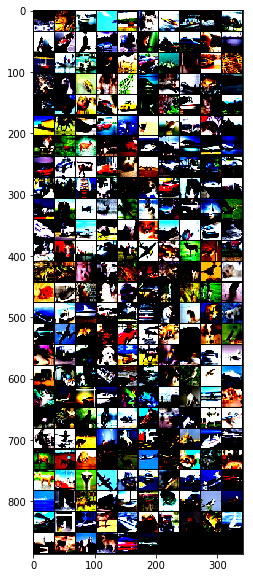

In [6]:
from torchvision.utils import make_grid 
def show_batch(dl):
    for xb, yb in dl:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.imshow(make_grid(xb, 10).permute(1,2,0))
        break 

show_batch(train_dl)




## Residual Blocks and Batch Normalization 

We will use a much larger model called wideREsNet22. 22 Convolutional layers! This adds a residual block as well, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers. 

Your layer now only needs to find what changes needs to be made in order to get to the output. 

Batch normalisation is to normalise the output of every layer. It might be possible that a particular channel becomes too large at a particular layer. 

batch normalisation takes the output of a layer, across each channel, it normalises it. Inside of this layer, it has a couple of parameters, standard deviation and mean for each channel. These will be learnt as well. 

This increases training performance overhead, however it enables lower losses to be achieved. 

In [7]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1= nn.Conv2d(3,3,kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(3,3,kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out+x)

In [8]:
simple_resnet = SimpleResidualBlock()

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break 

torch.Size([256, 3, 32, 32])


In [9]:
def conv_2d(ni, nf, stride =1, ks =3):
    return nn.Conv2d(in_channels=ni, out_channels=nf, kernel_size=ks, stride=stride, padding = ks//2, bias = False)
def bn_relu_conv(ni,nf):
    return nn.Sequential(nn.BatchNorm2d(ni),
                        nn.ReLU(inplace=True),
                        conv_2d(ni,nf))

class ResidualBlock(nn.Module):
    def __init__(self, ni, nf, stride =1):    # number of input, out channels
        super().__init__()    # initial batch norm
        self.bn = nn.BatchNorm2d(ni)   
        self.conv1 = conv_2d(ni,nf,stride,1) # first  convolutional layer, potentially increases the output channels
        self.conv2 = bn_relu_conv(nf,nf)  # adds another batch norm relu layer. 
        self.shortcut = lambda x:x      # returns the input without any change
        if ni!= nf: 
            self.shortcut = conv_2d(ni,nf, stride,1)    # if ni and nf are different, we then do the special conv
            
    def forward(self,x):
        x = F.relu(self.bn(x),inplace= True)  # get batch normalisation and relu
        r = self.shortcut(x)  
        x = self.conv1(x)   # perform the frist convolution
        x = self.conv2(x)*0.2   # scale down the output
        return x.add_(r) # now x = x + r, which is the original input. 
    
def make_group(N, ni, nf, stride):
    start = ResidualBlock(ni, nf, stride)
    rest = [ResidualBlock(nf, nf) for j in range(1,N)]
    return [start]+ rest


class Flatten(nn.Module):
    def __init__(self): 
        super().__init__()
    def forward(self,x): 
        return x.view(x.size(0),-1)
    
class WideResNet(nn.Module):
    def __init__(self, n_groups, N, n_classes, k=1, n_start =16):
        super().__init__()
        # increase channels to n_start usin gconv layers
        
        layers = [conv_2d(3,n_start)]
        n_channels= [n_start]
        
        # Add groups of Blocks 
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            layers += make_group(N, n_channels[i],
                                 n_channels[i+1],
                                 stride)

        layers += [nn.BatchNorm2d(n_channels[3]),
                  nn.ReLU(inplace = True),
                  nn.AdaptiveAvgPool2d(1),
                  Flatten(),
                  nn.Linear(n_channels[3],n_classes)]
        self.Features = nn.Sequential(*layers)
    
    def forward(self, x): return self.Features(x)

def wrn_22():
    return WideResNet(n_groups=3, N=3, n_classes =10, k =6)

In [10]:
model = wrn_22()

In [11]:
model

WideResNet(
  (Features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ResidualBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (shortcut): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): ResidualBlock(
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
 

In [12]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape: ', out.shape)
    break

images.shape: torch.Size([256, 3, 32, 32])
out.shape:  torch.Size([256, 10])


In [15]:
import fastai
from fastai.basic_data import DataBunch
from fastai.train import Learner
from fastai.metrics import accuracy

Fastai automatically creates the dataloaders, automatically sees if the system is using the gpu, automatically puts them to the gpu. 

The learner function already has things built in. 

the statement `learner.clip =0.1`sets the values of gradients to the range [-0.1,0.1]. Prevents undesirable changes in parameters due to large gradient values. 

FastAI also provides a helpful learning rate finder, which tries a range of learning rates, and helps to select a good learning rate by looking at the graph of loss vs learning rate.

In [31]:
batch_size = 50
data = DataBunch.create(train_ds, val_ds, bs = batch_size, path = './cifdata/cifar/')  
learner = Learner(data, model, loss_func = F.cross_entropy, metrics = [accuracy])
learner.clip=0.1

In [32]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


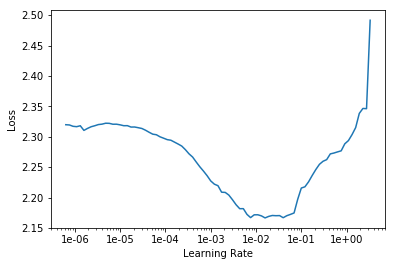

In [33]:
learner.recorder.plot()

In [34]:
learner.fit_one_cycle(9, 3e-3, wd = 1e-4)  # 9 epochs, wd is the weight decay. Weight decay is regularisation!.

epoch,train_loss,valid_loss,accuracy,time
0,1.186189,1.147617,0.594600,04:09
1,1.012634,0.992464,0.648300,04:50
2,0.747609,0.866591,0.707000,03:50
3,0.630029,0.626886,0.784700,03:42
4,0.506245,0.485026,0.835400,03:41
5,0.419081,0.426844,0.858000,03:26
6,0.350295,0.360909,0.877300,03:15
7,0.279651,0.329393,0.886700,04:10
8,0.265431,0.321697,0.893300,05:06


## Weight decay is really nice! 

This adds a penalty to the squares of the weights. This prevents any weight from gettting too large, ie a neuron being focused on the output of another single neuron. This is not great for generalisation of the model. By having this l2 regularisation, we discourage overfitting!

In [36]:
torch.save(model.state_dict(), "wideResnet.pth")

------------
## Legacy stuff 


### cuda 

To run the thing on GPU we write some helper functions to get default device, put data onto the gpu. A new class was also defined to automatically load data onto the gpu when a batch is sampled. This is a wrapper for the data loader we already have.

In [4]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
    

In [9]:
device = get_default_device()
print(device)

cuda


In [10]:
def to_device(data, device):
    if isinstance(data, (tuple, list)):
        return [to_device(x,device) for x in data]
    else:
        return data.to(device, non_blocking= True)

In [11]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl 
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)
        

In [12]:
## Define the model: 

model = nn.Sequential(
    nn.Conv2d(3,16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Conv2d(16,16, kernel_size=3, stride =1, padding =1),  
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Conv2d(16,16, kernel_size=3, stride =1, padding =1),  
    nn.ReLU(),
    nn.MaxPool2d(2,2),    

    nn.Conv2d(16,16, kernel_size=3, stride =1, padding =1),  
    nn.ReLU(),
    nn.MaxPool2d(2,2),    

    nn.Conv2d(16,16, kernel_size=3, stride =1, padding =1),  
    nn.ReLU(),
    nn.MaxPool2d(2,2),    

    nn.Flatten(),
    nn.Linear(16,10)
)
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)


Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=16, out_features=10, bias=True)
)

In [13]:
summary(model=model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 16, 16, 16]           2,320
              ReLU-5           [-1, 16, 16, 16]               0
         MaxPool2d-6             [-1, 16, 8, 8]               0
            Conv2d-7             [-1, 16, 8, 8]           2,320
              ReLU-8             [-1, 16, 8, 8]               0
         MaxPool2d-9             [-1, 16, 4, 4]               0
           Conv2d-10             [-1, 16, 4, 4]           2,320
             ReLU-11             [-1, 16, 4, 4]               0
        MaxPool2d-12             [-1, 16, 2, 2]               0
           Conv2d-13             [-1, 16, 2, 2]           2,320
             ReLU-14             [-1, 1

In [14]:
model(dataset[0][0].unsqueeze(0).to("cuda"))

tensor([[ 0.0637,  0.2273, -0.0917,  0.0782, -0.0101,  0.1783, -0.1207, -0.1452,
          0.0955, -0.0779]], device='cuda:0', grad_fn=<AddmmBackward>)

In [15]:
def batch_loss(model, loss_fn, xb,yb, opt=None, metrics = None):
    
    preds = model(xb)
    loss = loss_fn(preds,yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    metric_result = None
    if metrics is not None:
        metric_result = metrics(preds,yb)
        
    
    return loss, len(xb), metric_result

def accuracy(preds, yb):
    
    _, prediction = torch.max(preds,dim=1)
    
    return torch.sum(prediction==yb)/len(yb)

def evaluate(model, loss_fn, val_dl, metrics = None):
    with torch.no_grad():
        results = [batch_loss(model, loss_fn, xb,yb,metrics = metrics) for xb, yb in val_dl]
    
    val_loss, nums, val_metrics = zip(*results)
    
    ave_loss = np.sum(np.multiply(val_loss, nums))/np.sum(nums)
    ave_metrics = np.sum(np.multiply(val_metrics, nums))/np.sum(nums)
    
    return ave_loss, np.sum(nums), ave_metrics 



In [16]:
def fit(epochs, model, loss_fn, train_dl, val_dl, opt_fn = torch.optim.Adam, metrics = None, lr =0.005):
    
    opt = opt_fn(model.parameters(), lr = lr)
    loss_list = []
    metrics_list = []
    
    for epoch in range(epochs):
        
        for xb, yb in tqdm(train_dl): 
            loss,_,_ = batch_loss(model, loss_fn, xb,yb,opt=opt)
        
        val_loss, _, val_metrics = evaluate(model, loss_fn, val_dl, metrics = metrics)
    
        print("Epoch %d / %d, loss = %.4f, %s = %.4f" %(epoch+1, epochs, val_loss, metrics.__name__, val_metrics))
        
        loss_list.append(val_loss)
        metrics_list.append(val_metrics)
    return loss_list, metrics_list 



In [17]:
for xb, yb in train_dl: 
    print(xb.shape)
    print(yb.shape)
    print(batch_loss(model, F.cross_entropy, xb,yb))
    break 

torch.Size([100, 3, 32, 32])
torch.Size([100])
(tensor(2.2920, device='cuda:0', grad_fn=<NllLossBackward>), 100, None)


In [18]:
losses, metrics = fit(3, model, F.cross_entropy, train_dl, val_dl, torch.optim.Adam, metrics = accuracy, lr = 0.005)

  0%|▏                                                                                 | 1/400 [00:00<01:19,  5.00it/s]

Epoch 1 / 3, loss = 1.8356, accuracy = 0.3274


  0%|▏                                                                                 | 1/400 [00:00<01:11,  5.59it/s]

Epoch 2 / 3, loss = 1.5607, accuracy = 0.4240


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:18<00:00, 21.20it/s]


Epoch 3 / 3, loss = 1.4840, accuracy = 0.4586


In [25]:
import matplotlib.pyplot as plt
def predict(model, img):
    out = model(img.unsqueeze(0).to('cuda'))
    _, pred = torch.max(out,dim=1)
    print("The prediction is %s"  % dataset.classes[pred])
    plt.imshow(img.permute(1,2,0))

The prediction is airplane


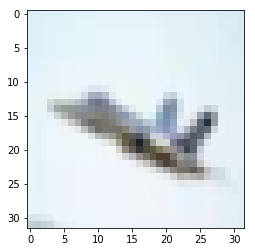

In [26]:
predict(model,dataset[0][0])

In [16]:
import math
def f(t,k):
    c = 1/math.sqrt((k-2)**2+4*(k-1))
    a1 = ((k-2+math.sqrt((k-2)**2+4*(k-1)))/2)**t
    a2 = ((k-2-math.sqrt((k-2)**2+4*(k-1)))/2)**t
    return c*(a1-a2)

print(f(3,3))

3.0


In [ ]:
a = 3141592653589793238462643383279502884197169399375105820974944592
b = 2718281828459045235360287471352662497757247093699959574966967627


def karatsuba(a,b):
    a = str(a)
    b = str(b)
    if len(a)>1:
        ab = int(a[:len(a)//2])
        cd = int(a[len(a)//2:])
        ef = int(b[:len(b)//2])
        gh = int(b[len(b)//2:])
        return int(karatsuba(ab,ef)*10**len(a)//2+karatsuba(cd,ef)*10**(len(a)//2)
                +karatsuba(ab,gh)*10**(len(a)//2+karatsuba(cd,gh))
               )
        print(a)
    else:
        return int(a)*int(b)

In [ ]:
karatsuba(1234,5678)